In [1]:
import torch.nn.functional as F
import voc12.dataloader
import numpy as np
import argparse
import torch
import os
from PIL import Image
from torch.utils.data import DataLoader
from misc import pyutils, torchutils
from net.resnet50_cam import CAM, Net, ReCAM    
from misc import imutils
import matplotlib.pyplot as plt

In [15]:
val_list = '/Users/Andy/Projects/front_door_cam/voc12/val.txt'
voc12_root = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012'
baseline_cam_weight_path = '/Users/Andy/Projects/resnet50_baseline_512.pth'
frontdoor_cam_weight_path = '/Users/Andy/Projects/resnet50_fdsi_exp_match_01_laste.pth'

val_dataset = voc12.dataloader.VOC12ClassificationDatasetMSF(val_list,
                                                          voc12_root=voc12_root,
                                                          scales=(1.0, 0.5, 1.5, 2.0))
data_loader = DataLoader(val_dataset, shuffle=False)

model_baseline = CAM()
model_frontdoor = CAM()
model_baseline.eval()
model_frontdoor.eval()
model_baseline.load_state_dict(torch.load(baseline_cam_weight_path, map_location='cpu'))
model_frontdoor.load_state_dict(torch.load(frontdoor_cam_weight_path, map_location='cpu'))

<All keys matched successfully>

In [21]:
data_iter = iter(data_loader)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)

with torch.no_grad():
    img_name = pack['name'][0]
    imgs = pack['img']
    label = pack['label'][0]
    size = pack['size']
    
    print(label)

    strided_up_size = imutils.get_strided_up_size(size, 16)

    baseline_outputs = [model_baseline(img[0]) for img in pack['img']]
    frontdoor_outputs = [model_frontdoor(img[0]) for img in pack['img']]

    baseline_highres_cam = [F.interpolate(torch.unsqueeze(
                o, 1), strided_up_size, mode='bilinear', align_corners=False) for o in baseline_outputs]
    baseline_highres_cam = torch.sum(torch.stack(baseline_highres_cam, 0), 0)[
                :, 0, :size[0], :size[1]]
    
    frontdoor_highres_cam = [F.interpolate(torch.unsqueeze(
                o, 1), strided_up_size, mode='bilinear', align_corners=False) for o in frontdoor_outputs]
    frontdoor_highres_cam = torch.sum(torch.stack(frontdoor_highres_cam, 0), 0)[
                :, 0, :size[0], :size[1]]

    valid_cat = torch.nonzero(label)[:, 0]

    baseline_highres_cam = baseline_highres_cam[valid_cat]
    frontdoor_highres_cam = frontdoor_highres_cam[valid_cat]
    baseline_highres_cam /= F.adaptive_max_pool2d(baseline_highres_cam, (1, 1)) + 1e-5
    frontdoor_highres_cam /= F.adaptive_max_pool2d(frontdoor_highres_cam, (1, 1)) + 1e-5
    

print(baseline_highres_cam.min(), baseline_highres_cam.max())
print(frontdoor_highres_cam.min(), frontdoor_highres_cam.max())

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0.])
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)


2007_000129


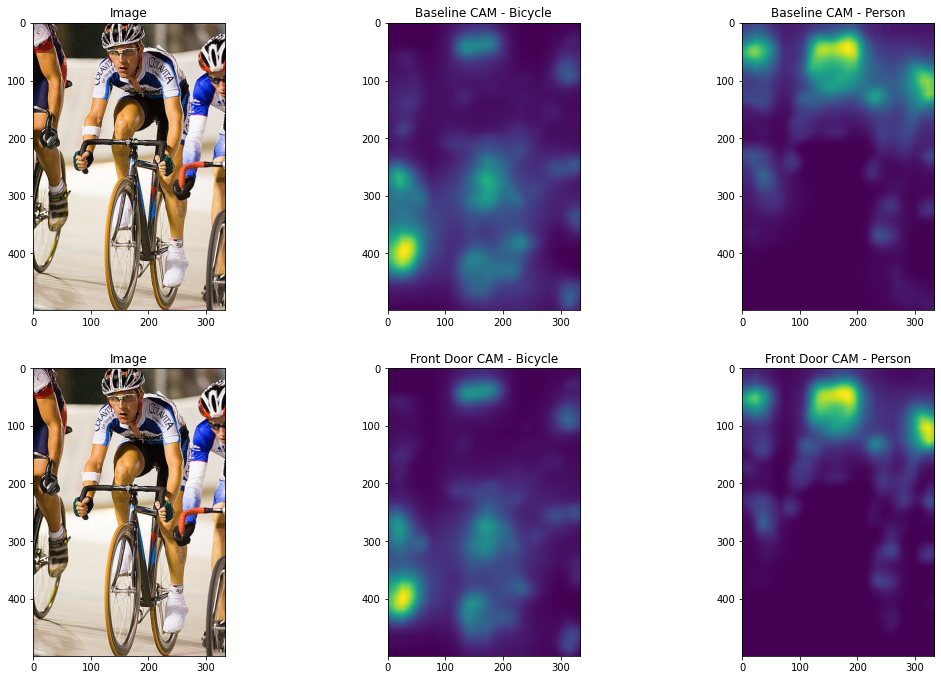

In [22]:
im = Image.open(os.path.join(voc12_root, 'JPEGImages', img_name + '.jpg'))
print(img_name)
fig = plt.figure(figsize=(18,18))
ax1 = fig.add_subplot(331)
plt.title('Image')
ax1.imshow(im)
ax2 = fig.add_subplot(332)
plt.title('Baseline CAM - Bicycle')
ax2.imshow(baseline_highres_cam[0].squeeze())
ax3 = fig.add_subplot(333)
plt.title('Baseline CAM - Person')
ax3.imshow(baseline_highres_cam[1].squeeze())
ax1 = fig.add_subplot(334)
plt.title('Image')
ax1.imshow(im)
ax2 = fig.add_subplot(335)
plt.title('Front Door CAM - Bicycle')
ax2.imshow(frontdoor_highres_cam[0].squeeze())
ax3 = fig.add_subplot(336)
plt.title('Front Door CAM - Person')
ax3.imshow(frontdoor_highres_cam[1].squeeze())

# Front-Door Adjustment and Style Intervention

Consider the following Causal Graph, this graph depicted the causal relationship between the image $X$ and its weak localization mask $Y$. The tag $Z$ is the image-level label assigned to each image. For instance, it could be "bicycle" and "person" for the image above. Moreover, we assume that each observed image $X$ has a generation process based on Style $S$ (e.g., colour, lighting conditions, texture) and Content $C$ (e.g., objects). 

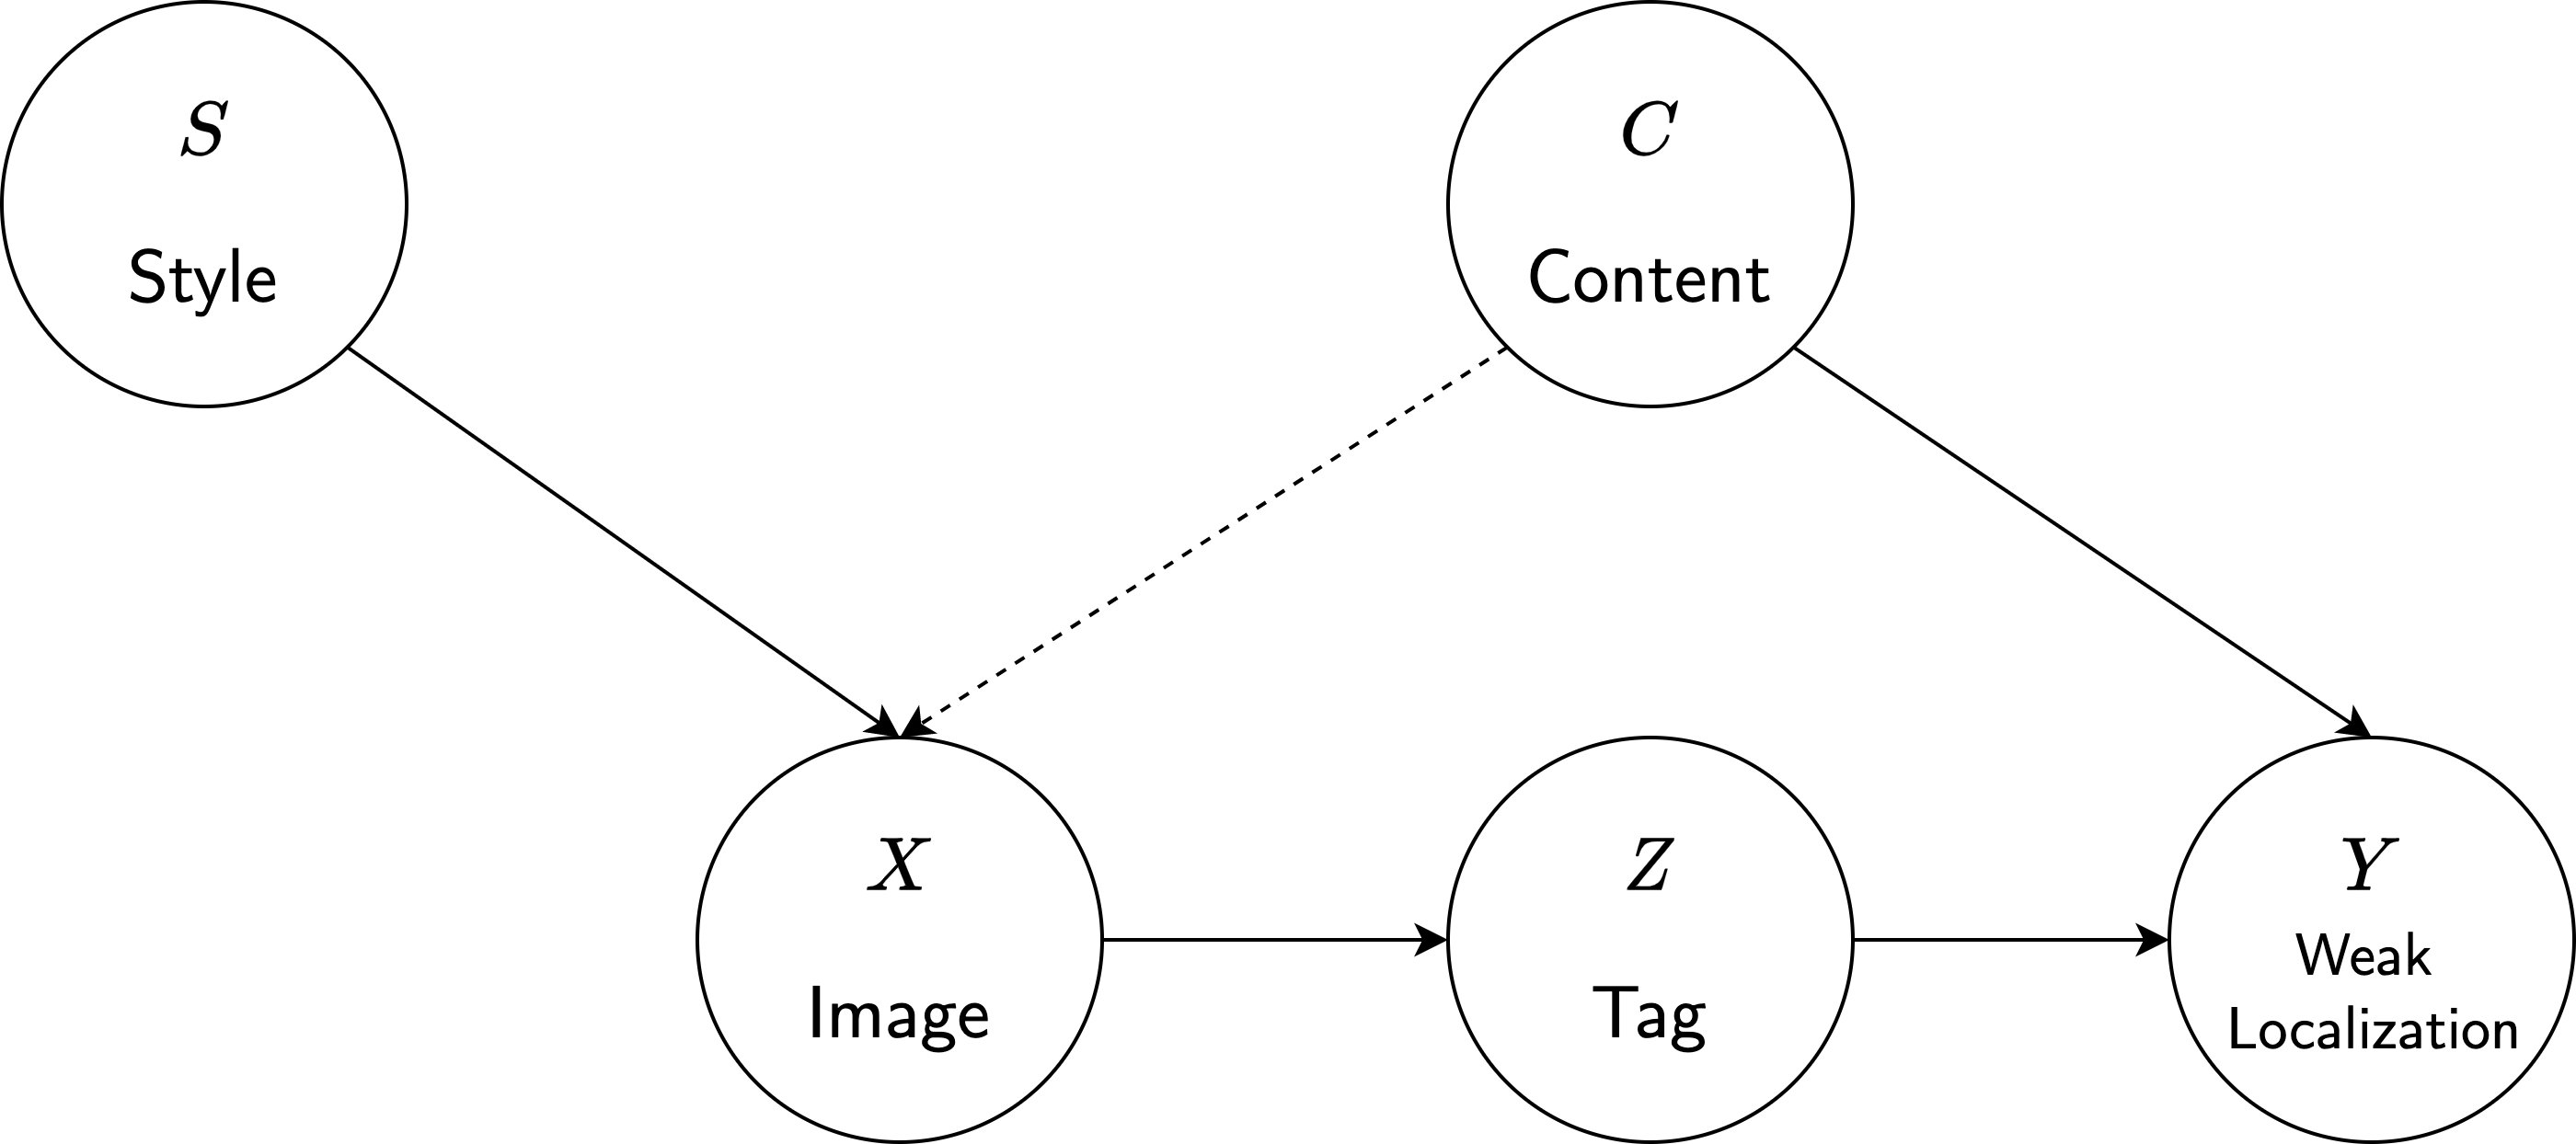



$C\rightarrow X$ and $C\rightarrow Y$. The content prior $C$ identifies the objects (e.g., people and bicycle) and pictures the relationships among objects (e.g. person on the bicycle) in a scene. Hence, it determines what to picture in an image $X$. Moreover, it also causes weak localization results $Y$. 


$S \rightarrow X$ The style prior $S$ inpaints the characteristics (e.g., colour and shape) of objects and background in each image $X$. 

$S \rightarrow X \rightarrow Z \rightarrow Y$ This path possessed ambiguity in image $X$ for weakly-supervised semantic segmentation tasks. Due to the weak supervision, many object-irrelevant regions generated from style $S$ in image $X$ are involved in learning the association with image-level label $Z$, which should be eliminated. (see Figure 1 from "Causal Attention for Unbiased Visual Recognition by Tan Wang, Chang Zhou, Qianru Sun, Hanwang Zhang which was published on ICCV 2021")

$X\rightarrow Z$. The tag $Z$ of an image is determined by the image $X$, as the tags are annotated by human-selected classes, instead of annotating every class of objects. Thus, content prior $C$ cannot directly affect the labels $Z$ of an image. 

$Z\rightarrow Y$. The weak localization masks $Y$ are determined by the tag $Z$ as the tag(s) restricts the object to be localized. For instance, if the background of an image contains semantic objects, if the tag doesn't include that class of the object, the localization mask $Y$ will assign "background" to those pixels.


### Front-Door Adjustment
Based on the causal diagram, we can see content $C$ confounds $X$ and $Y$ via the backdoor path from $X$ to $Y$. However, $C$ is unobservable and hence cannot be used to block the backdoor path from $X$ to $Y$. Nevertheless, by applying two consecutive applications of the backdoor criterion, we can identify the causal effect $P(Y = y|do(X=x))$. This is also known as the **Front-Door Adjustment**. 

As the image tag $Z$ satisfies the front-door criterion relative to $(X, Y)$, then the causal effect of $X$ on $Y$ is identifiable is given by the formula

$$
P(y|do(x)) = \sum_zP(z|x)\sum_{x'}P(y|x',z)P(x')
$$

The derivation is as follows. We first note the causal effect of $X$ on $Z$ is identifiable, as there is no backdoor path from $X$ to $Z$. Thus, by **Back-Door Adjustment**, we have

$$
P(Z=z|do(X=x)) = P(Z=z|X=x)
$$

Second, we note the effect of $Z$ of $Y$ is also identifiable, since the backdoor path from $Z$ to $Y$, $Z\leftarrow X \leftarrow C \rightarrow Y$, can be blocked by conditioning on $X$. Thus, by **Back-Door Adjustment**, we have

$$
P(Y=y|do(Z=z)) = \sum_x P(Y=y|Z=z,X=x)
$$

Combining the above two equations gives us the results produced by **Front-Door Adjustment**. 


### Style Intervention

Furthermore, as we mentioned above, style $S$ also poses ambiguities for learning object-irrelevant features. Thus, we proposed to regularize the learning processing by a *style invariant regularization term*, inspired by "Representation Learning via Invariant Causal Mechanisms" by Jovana Mitrovic, Brian McWilliams, Jacob Walker, Lars Buesing, Charles Blundell which was published at ICLR 2021. 

Essentially, as content $C$ should contain all necessary information to predict $Z$ as well as $Y$, we hypothesize that $C$ is invariant under $S$. In other words,

$$
p^{S=s_i}(Z|X_{C_k}) = p^{S=s_j}(Z|X_{C_k})~~\forall s_i, s_j \in \mathcal{S}~\text{and}~C_k \in C
$$

Specifically, this invariant property indicates using $C$ as a representation allows for us to predict targets stably across different style perturbations.

To intervene $S$, we propose to use a proxy task to learn the style invarant representation by data augmentation. In other words, we add a regularization term

$$
KL(p^{a_{lk}}(Z|f(X)), p^{a_{qt}}(Z|f(X)))
$$

where $a_{lk}$ denotes a pair of data augmentation, and $a_l$ and $a_k\in\mathcal{A}$, and $\mathcal{A} = \{a_1, ..., a_m\}$ is the set of data augmentations which simulate interventions on style $S$. 

### Loss 

Finally, our loss objective is a combinaiton of the front-door criterion plus the style invariant regularization term:

$$
CE(\sum_zP(z|x)\sum_{x'}P(y|x',z)P(x'), \hat{Z}) + KL(p^{a_{lk}}(Z|f(X)), p^{a_{qt}}(Z|f(X)))
$$


# Front-Door Adjustment for Weakly-Supervised Semantic Segmentation

- $P(z|x)$: A classification network trained on the dataset will produce a probability distribution $P(z|x)$ over the given classes in a dataset. For instance, in PASCAL VOC, it will be $B\times 20$. 
- $P(y|x, z)$: With the class activation map, we also can estimate $P(y|x, z)$ which contains the attention map over the given classes in a dataset. For instance, in PASCAL VOC, it will be $B\times 20 \times H \times W$.
- $P(x)$: Under the assumption $P(x)$ is uniform, i.e., $\frac{1}{N}$ where $N$ is the number of images in a given dataset. This assumption is reasonable as the training samples are equiprobable. 

However, the tricky part of utilizing front-door adjustment is the summations over all $x$ in the dataset, i.e., $\sum_{x'}P(y|x',z)P(x')$.  

## Solution 1: Entire Dataset
It is also fast to compute $P(y|x',z)$ for the entire training set, by utilizing parallel computing. It takes about three minutes to compute all CAMs for the training set of the PASCAL VOC 2012 classification partition. 

## Solution 2: Batch

To avoid computing $P(y|x,z)$ for all the image $X$ in the dataset, we just take advantage of the data in each batch. 

## Solution 3: Memory Bank
To avoid computing $P(y|x,z)$ for all the image $X$ in the dataset, we can create a memory bank $M$ that contains a subset of training data. This is similar to the memory buffer in the reinforcement learning setting. The image in the memory bank can be updated in every iteration. It is reasonable to include images with a uniform class distribution. 


# Optimization

## Solution 1: Multiple Instance Learning

$P(y|do(x))$ produces one score $s_{i,j}^k = Y^k_{i,j}$ for each pixel location $(i,j)$ for class $k$. However, the pixel-level annotation is unobservabale and we only have image-level tag for each image. Thus, an aggreation function is required. To aggregate the pixel-level scores into a single image-level scores. The $aggreg$ function can be the convex approximation of the max function `Log-Sum-Exp`

$$
s^k = \frac{1}{r}\log\Big[\frac{1}{h^ow^o}\sum_{i,j}\exp(rs_{i,j}^k)\Big]
$$

where $r$ controls how smooth the approximation to be, and $h^ow^o$ is the height and width of the predicted class activation map. 

For simplicity, we can also aggreate by taking the `Mean`

$$
s^k = \frac{1}{N}\Big[\sum_{i,j}s_{i,j}^k\Big]
$$

Further, we interpret $s^k$ as the image-level class scores and by applying a softmax 

$$
p(y|do(x)) = \frac{e^{s^k}}{\sum_{c\in \mathcal{C}}e^{s^c}}
$$

Finally, we maximize the log-likelihood with respect to the classification network $\theta$. 

$$
\mathcal{L}(\theta) = \sum_{(x,k)}\Big[s^k - \log\sum_{c\in \mathcal{C}}e^{s^c}\Big]
$$